In [1]:
# snippet from ~/Library/Jupyter/nbextensions/snippets/snippets.json
# basic
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import csv
import os, sys
import dill
import seaborn as sns

from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

RANDOM_STATE = 777

# Set up Pipeline and Model

## Import Stems

In [2]:
alnc_path = '/Users/nknezek/Documents/Insight_local/project/data/ALNC/Cleaned/NewspaperMapCorpus_03_03_2014_cleaned/'

stop_stems = dill.load(open("/Users/nknezek/Documents/Insight_local/project/data/wordlists/stop_words/stop_stems.m",'rb'))
vocab_stems = dill.load(open("/Users/nknezek/Documents/Insight_local/project/data/wordlists/SCOWL-custom/vocab_stems.m",'rb'))

## TF-IDF vectorizer with tokenizer and stemmer

In [3]:
## Do this now in separate document "Fit TF-IDF transform"


# tokenizer = RegexpTokenizer(r'[a-zA-Z]+')
# stemmer = SnowballStemmer('english')

# def tokenize(text):
#     tokens = tokenizer.tokenize(text.lower())
#     stems = [stemmer.stem(x) for x in tokens]
#     return stems

# # vectorize the articles and compute count matrix
# tfidf_vectorizer = TfidfVectorizer(vocabulary=list(vocab_stems), stop_words=stop_stems, tokenizer=tokenize)

### Load pre-trained TF-IDF vectorizer

In [4]:
tfidf_vectorizer = dill.load(open('tfidf_vectorizer.m','rb'))

## Make Model

In [5]:
# Look up newton-cg. Naive bayes
estimator = LogisticRegression(class_weight='balanced',
                               solver='newton-cg',
                               multi_class='multinomial',
                               n_jobs=-1,
                               random_state=RANDOM_STATE)

## Make Pipeline

In [6]:
prep = make_pipeline(tfidf_vectorizer,None)

# Transform vectors

In [87]:
state = 'AK/'
town = 'Anchorage/'
statetown = state + town

def get_filenames_for_town(alnc_path, statetown, verbose=False):
    papers = os.listdir(alnc_path + statetown)
    files_list = []
    for p in papers:
        files_p = os.listdir(alnc_path + statetown + p)
        files_list += [alnc_path + statetown + p + '/' + x for x in files_p]
    if verbose:
        print('{} files found for {}'.format(len(files_list), statetown))
    return files_list

file_list = get_filenames_for_town(alnc_path, statetown)
file_list[:4]

['/Users/nknezek/Documents/Insight_local/project/data/ALNC/Cleaned/NewspaperMapCorpus_03_03_2014_cleaned/AK/Anchorage/www.thebristolbaytimes.com/2014-1-28-article38.cleaned',
 '/Users/nknezek/Documents/Insight_local/project/data/ALNC/Cleaned/NewspaperMapCorpus_03_03_2014_cleaned/AK/Anchorage/www.thebristolbaytimes.com/2014-1-28-article28.cleaned',
 '/Users/nknezek/Documents/Insight_local/project/data/ALNC/Cleaned/NewspaperMapCorpus_03_03_2014_cleaned/AK/Anchorage/www.thebristolbaytimes.com/2013-9-21-article1.cleaned',
 '/Users/nknezek/Documents/Insight_local/project/data/ALNC/Cleaned/NewspaperMapCorpus_03_03_2014_cleaned/AK/Anchorage/www.thebristolbaytimes.com/2014-1-21-article60.cleaned']

In [95]:
def load_one_file(file):
    with open(file,'r') as f:
        raw_text = f.read()
    return raw_text

def make_corpus(file_list):
    for file in file_list:
        yield load_one_file(file)


In [129]:
with open(file_list[0], 'r') as content_file:
    raw_text = content_file.read()
tfidf_vectorizer.transform([raw_text])

<1x127461 sparse matrix of type '<class 'numpy.float64'>'
	with 44 stored elements in Compressed Sparse Row format>

In [130]:
def tfidf_many_files(file_list,tfidf_vectorizer):
    corpus = make_corpus(file_list)
    return tfidf_vectorizer.transform(corpus)

In [131]:
tfidf_many_files(file_list[:4], tfidf_vectorizer)

<4x127461 sparse matrix of type '<class 'numpy.float64'>'
	with 416 stored elements in Compressed Sparse Row format>

In [136]:
def process_towns(alnc_path, statetowns, tfidf_vectorizer, skip):
    tfidf_list = []
    labels = []
    files_list = []
    for i, sttn in enumerate(statetowns):
        files = get_filenames_for_town(alnc_path, sttn)[::(skip + 1)]
        labels += [i] * len(files)
        files_list += files
    tfidf_matrix = tfidf_many_files(files_list, tfidf_vectorizer)
    return labels, tfidf_matrix

In [137]:
statetowns = ['AK/Anchorage/', 'CA/Berkeley/', 'TX/Denton/']

labels, tfidf_matrix = process_towns(
    alnc_path, statetowns, tfidf_vectorizer, skip=10)

In [138]:
tfidf_matrix.shape

(4270, 127461)

In [139]:
len(labels)

4270

In [140]:
dill.dump((labels,tfidf_matrix),open('tfidf_3citytest_pipeline.m','wb'))

# PCA of TF-IDF vectors

In [141]:
from sklearn import decomposition

In [142]:
pca = decomposition.TruncatedSVD(n_components=3)
pca.fit(tfidf_matrix)
X = pca.transform(tfidf_matrix)

In [143]:
X.shape

(4270, 3)

In [144]:
import ipyvolume as ipv

In [145]:
X.shape

(4270, 3)

In [146]:
len(labels)

4270

In [147]:
statetowns

['AK/Anchorage/', 'CA/Berkeley/', 'TX/Denton/']

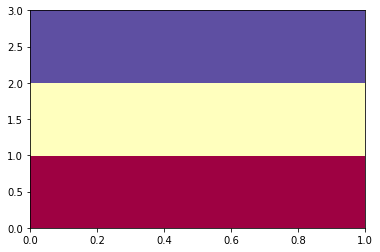

In [148]:
vals = np.array([0,1,2])
cbarcolors = plt.cm.Spectral((vals+.05)/2.1)

plt.pcolor([0,1],list(vals)+[3],vals[:,None],cmap=plt.cm.Spectral)

In [149]:
fig = ipv.figure()
colorvals = (np.array(labels)+.05)/2.1
colors = plt.cm.Spectral(colorvals)
scatter = ipv.scatter(X[::1,0], X[::1,1], X[::1,2], marker='sphere',size=.5,color=colors[:,:3])
ipv.show()


In [150]:
ipv.save("3city_scatter_stems_sample_skip10.html")

# Train model

In [151]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [153]:
X_train, X_test, y_train, y_test = train_test_split(
    tfidf_matrix, labels, test_size=0.2, random_state=RANDOM_STATE)

In [154]:
X_train.shape

(3416, 127461)

In [155]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, learning_curve, validation_curve, GridSearchCV

In [156]:
# Look up newton-cg. Naive bayes
estimator = LogisticRegression(class_weight='balanced',
                               solver='newton-cg',
                               multi_class='multinomial',
                               n_jobs=-1,
                               random_state=RANDOM_STATE)

## Find Best Regularization Parameter C

In [59]:
def get_validation_curve(estimator, X, y, cv=None,
                        n_jobs=1, param_range=np.linspace(.1, 1.0, 5)):
    """
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html
    """
    train_scores, test_scores = validation_curve(
        estimator, X, y, "C", cv=cv, n_jobs=n_jobs, param_range=param_range, scoring="accuracy")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    return train_scores_mean, train_scores_std, test_scores_mean, test_scores_std

def plot_validation_curve(train_scores_mean, train_scores_std, test_scores_mean,test_scores_std, param_range, title=None, ylim=None,):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("C (1 / regularization strength)")
    plt.ylabel("Accuracy score")

    plt.grid()
    plt.semilogx(param_range, train_scores_mean, 'o-', label="Training score",
                 color="darkorange")
    plt.fill_between(param_range, train_scores_mean - (2*train_scores_std),
                 train_scores_mean + (2*train_scores_std), alpha=0.2,
                 color="darkorange")
    plt.semilogx(param_range, test_scores_mean, 'o-', label="Cross-validation score",
                 color="navy")
    plt.fill_between(param_range, test_scores_mean - (2*test_scores_std),
                 test_scores_mean + (2*test_scores_std), alpha=0.2,
                 color="navy")
    plt.legend(loc="best")
    return plt

In [60]:
param_range = np.logspace(-2, 4, 10)
train_scores_mean, train_scores_std, test_scores_mean, test_scores_std = get_validation_curve(
    estimator,
    X=X_train,
    y=y_train,
    param_range=param_range)

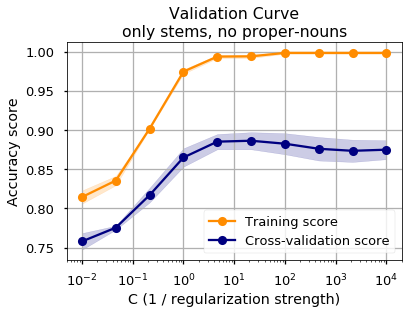

<Figure size 432x288 with 0 Axes>

In [61]:
sns.set_context("talk", font_scale=1.0)
title = "Validation Curve\nonly stems, no proper-nouns"
plot_validation_curve(
    train_scores_mean,
    train_scores_std,
    test_scores_mean,
    test_scores_std,
    param_range,
    title=title,
)

plt.show()
plt.savefig('validation_curve_stems_nopropernouns.pdf')

In [62]:
param_range = np.logspace(.5, 2.5, 10)
train_scores_mean, train_scores_std, test_scores_mean, test_scores_std = get_validation_curve(
    estimator,
    X=X_train,
    y=y_train,
    param_range=param_range)

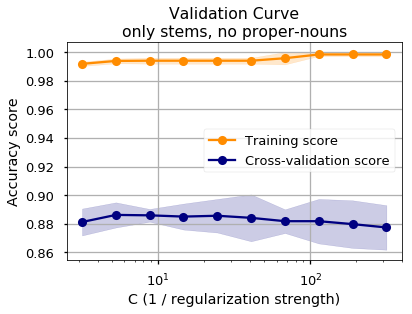

<Figure size 432x288 with 0 Axes>

In [63]:
sns.set_context("talk", font_scale=1.0)
title = "Validation Curve\nonly stems, no proper-nouns"
plot_validation_curve(
    train_scores_mean,
    train_scores_std,
    test_scores_mean,
    test_scores_std,
    param_range,
    title=title,
)

plt.show()
plt.savefig('validation_curve_stems_nopropernouns_zoomed.pdf')

In [158]:
C_best = 30

## Find size of dataset needed

Now that we know how strong our regularization needs to be, let's check out the learning curve to ensure that the 80 split for training is sufficiently large to capture variation in the dataset. First, I've defined the function for plotting the learning curve.

In [65]:
def get_learning_curve(estimator,
                       X,
                       y,
                       cv=None,
                       n_jobs=1,
                       train_sizes=np.linspace(.1, 1.0, 5)):
    """     
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
    """
    train_sizes, train_scores, test_scores = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        scoring="accuracy")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    return train_scores_mean, train_scores_std, test_scores_mean, test_scores_std

def plot_learning_curve(
        train_sizes,
        train_scores_mean,
        train_scores_std,
        test_scores_mean,
        test_scores_std,
        title,
        ylim=None,
):
    """
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training sample size")
    plt.ylabel("Accuracy score")
    plt.grid()
    plt.fill_between(
        train_sizes,
        train_scores_mean - (2 * train_scores_std),
        train_scores_mean + (2 * train_scores_std),
        alpha=0.1,
        color="r")
    plt.fill_between(
        train_sizes,
        test_scores_mean - (2 * test_scores_std),
        test_scores_mean + (2 * test_scores_std),
        alpha=0.1,
        color="g")
    plt.plot(
        train_sizes,
        train_scores_mean,
        'o-',
        color="r",
        label="Training score")
    plt.plot(
        train_sizes,
        test_scores_mean,
        'o-',
        color="g",
        label="Cross-validation score")

    plt.legend(loc="best")
    return plt



And in the graph below we can see that we would not benefit from adding more training data

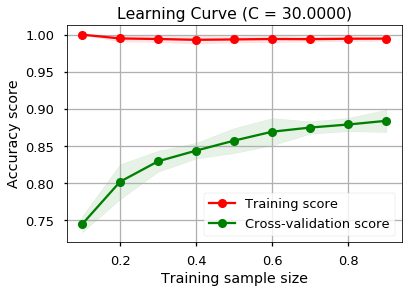

In [66]:
train_sizes = np.linspace(0.1, 0.9, 9)

estimator = LogisticRegression(
    class_weight='balanced',
    solver='newton-cg',
    multi_class='multinomial',
    n_jobs=-1,
    C=C_best,
    random_state=RANDOM_STATE)

train_scores_mean, train_scores_std, test_scores_mean, test_scores_std = get_learning_curve(
    estimator, X=X_train, y=y_train, train_sizes=train_sizes)

sns.set_context("talk", font_scale=1.0)
title = 'Learning Curve (C = {0:.4f})'.format(C_best)
plot_learning_curve(
    train_sizes,
    train_scores_mean,
    train_scores_std,
    test_scores_mean,
    test_scores_std,
    title,
)
plt.show()

## Train on the entire training set and make predictions with the testing set

In [159]:
clf = LogisticRegression(C=C_best,
                         class_weight='balanced',
                         solver='newton-cg', 
                         multi_class='multinomial',
                         n_jobs=-1,
                         random_state=RANDOM_STATE)
clf.fit(X_train, y_train)

y_predicted = clf.predict(X_test)

Save the trained classifier!

In [160]:
dill.dump(clf, open('trained_clf_multinomial_skip10.m','wb'))


# Analyze Trained Model


In [161]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.899, precision = 0.900, recall = 0.899, f1 = 0.899


##  plot the confusion matrix

In [162]:
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix_with_labels(cm,
                                      classes,
                                      normalize=False,
                                      title='Confusion matrix',
                                      cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print(cm)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    #     plt.title(title)
    #     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return plt

Confusion matrix, without normalization


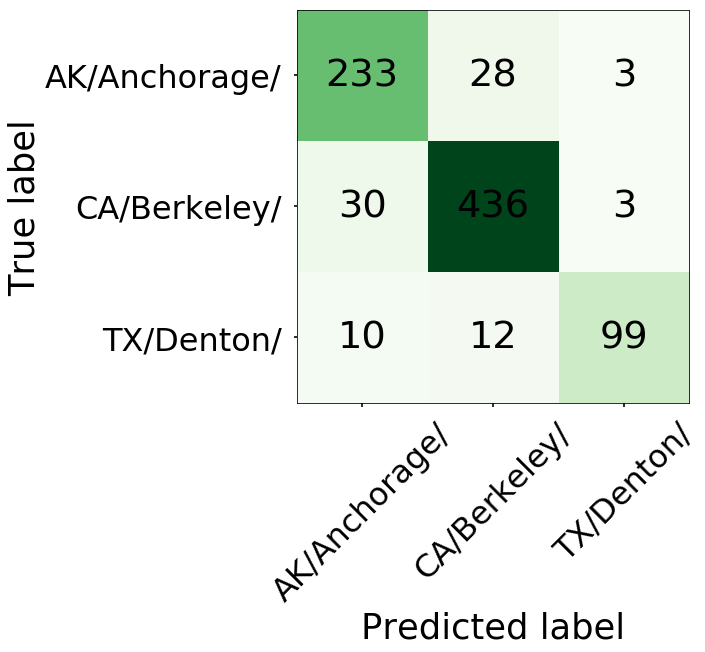

In [163]:
cm = confusion_matrix(y_test, y_predicted)
sns.set_context("poster", font_scale=2.0)

fig = plt.figure(figsize=(10, 10))
ax = fig.gca()
for (j,i),label in np.ndenumerate(cm):
    ax.text(i,j,label,ha='center',va='center')
plot = plot_confusion_matrix_with_labels(cm, classes=statetowns, normalize=False, cmap=plt.cm.Greens)
plot.show()

## Find most important features

In [165]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottoms':bottom
        }
    return classes

importance = get_most_important_features(tfidf_vectorizer, clf, 10)

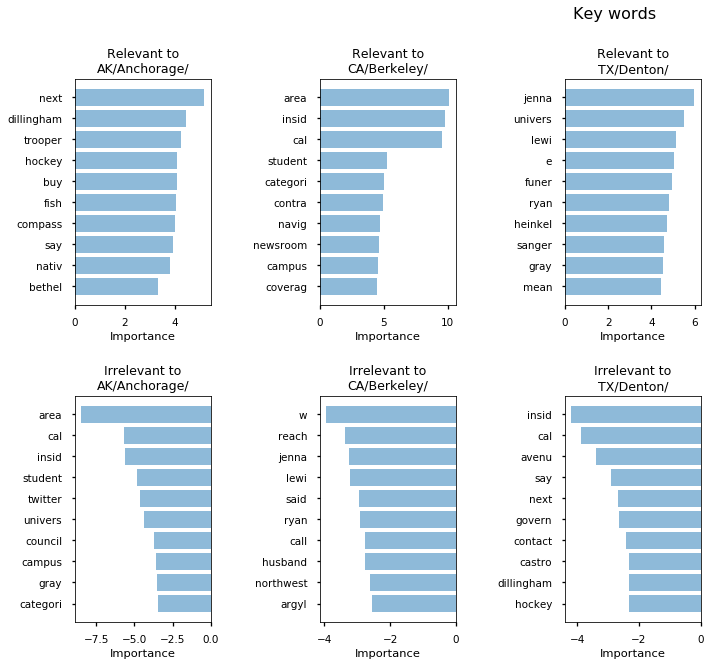

In [166]:
def plot_important_words(importance, name, keys=('bottoms', 'tops',)):
    fig = plt.figure(figsize=(20, 10))
    categories = ('K-2','3-5', '6-8', '9-12')
    for idx, category in enumerate(statetowns):
        
        top_scores = [a[0] for a in importance[idx][keys[1]]]
        top_words = [a[1] for a in importance[idx][keys[1]]]
        bottom_scores = [a[0] for a in importance[idx][keys[0]]]
        bottom_words = [a[1] for a in importance[idx][keys[0]]]
        
        y_pos = np.arange(len(top_words))
        
        plt.subplot(2, 5, 1 + idx)
        plt.barh(y_pos,top_scores, align='center', alpha=0.5)
        plt.title('Relevant to\n{}'.format(category))
        plt.yticks(y_pos, top_words)
        plt.suptitle(name, fontsize=16)
        plt.xlabel('Importance')

        plt.subplot(2, 5, 6 + idx)
        plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
        plt.title('Irrelevant to\n{}'.format(category))
        plt.yticks(y_pos, bottom_words)
        plt.suptitle('Key words', fontsize=16)
        plt.xlabel('Importance')
    
    plt.subplots_adjust(wspace=0.8, hspace=0.4)
    plt.show()
    
sns.set_context("talk", font_scale=0.8)
plot_important_words(importance, "Most important words for relevance")
sns.set_context("talk", font_scale=1.5)

# Create pipeline

In [168]:
from sklearn.pipeline import make_pipeline
c = make_pipeline(tfidf_vectorizer, clf)

In [ ]:
dill.dump(c,open('trained_model.m','wb'))

# Test model on own text

In [177]:
text_ak = "Try our new app, perfect for fishing, hunting, and all of your outdoor needs! Also great for hockey."
c.predict_proba([text_ak])

array([[9.94774e-01, 4.46215e-03, 7.63899e-04]])

In [178]:
text_ca = "Have fun by the bay with sushi and sake!"
c.predict_proba([text_ca])

array([[0.23569, 0.65583, 0.10848]])

## Use LimeText to Explain words

In [179]:
from lime.lime_text import LimeTextExplainer

In [180]:
# my_tokenizer = lambda text: tokenize_article_content(text,tokenizer,stop_stems,go_stems,stemmer)
explainer = LimeTextExplainer(class_names=statetowns)

In [181]:
exp = explainer.explain_instance(text_ca, c.predict_proba, num_features=6, labels=[1])
exp.show_in_notebook(text=True)

/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


In [182]:
exp = explainer.explain_instance(text_ak, c.predict_proba, num_features=6, labels=[1])
exp.show_in_notebook(text=True)

/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
